In [132]:
import matplotlib.pyplot as plt
import pandas as pd
import ast
import wandb

api = wandb.Api()
entity = "disco-conv-splade"   # from your code
project = "disco-conv-splade_evaluation"

runs = api.runs(f"{entity}/{project}")

run_list = []
for run in runs:
    if "ckpt" in ast.literal_eval(run.config["config"])['out_dir']:
        run_list.append(run)
df_list = []

for run in run_list:
    # convert summary (dict-like) to DataFrame with one row
    tmp_df = pd.DataFrame([dict(run.summary)])
    
    # extract run_name from config
    config_dict = ast.literal_eval(run.config["config"])
    try:
        run_checkpoint = int(config_dict['checkpoint_dir'].split('-')[-1])
        run_name = config_dict['checkpoint_dir'].split('/')[-2]
        tmp_df['run_name'] = run_name
        tmp_df['run_checkpoint'] = run_checkpoint
        df_list.append(tmp_df)
    except:
        pass


# concatenate all rows into a single DataFrame
runs_df = pd.concat(df_list, ignore_index=True)

runs_df.head()
# Filter metric columns
metric_cols = [col for col in runs_df.columns if col.startswith("TOPIOCQA/")]

# Sort by run_name
runs_df = runs_df.sort_values(by="run_checkpoint")

# for the checkpoints, if the run_name contains _00, multiply run_checkpoint by 2
runs_df['run_checkpoint'] = runs_df.apply(
    lambda row: row['run_checkpoint'] * 2 if '_0' in row['run_name'] else row['run_checkpoint'],
    axis=1
)
runs_df['run_checkpoint'] = runs_df.apply(
    lambda row: row['run_checkpoint'] * 2 if 'standard' in row['run_name'] else row['run_checkpoint'],
    axis=1
)

runs_df['run_checkpoint'] = runs_df.apply(
    lambda row: row['run_checkpoint'] * 2 if '1_neg' in row['run_name'] else row['run_checkpoint'],
    axis=1
)

In [133]:
df_list

config_dict = ast.literal_eval(run.config["config"])
run_checkpoint = int(config_dict['checkpoint_dir'].split('-')[-1])
run_name = config_dict['checkpoint_dir'].split('/')[-2]
tmp_df['run_name'] = run_name
tmp_df['run_checkpoint'] = run_checkpoint
df_list.append(tmp_df)
print(run_name)

disco_TOPIOCQA_mistral_standard_1764855442


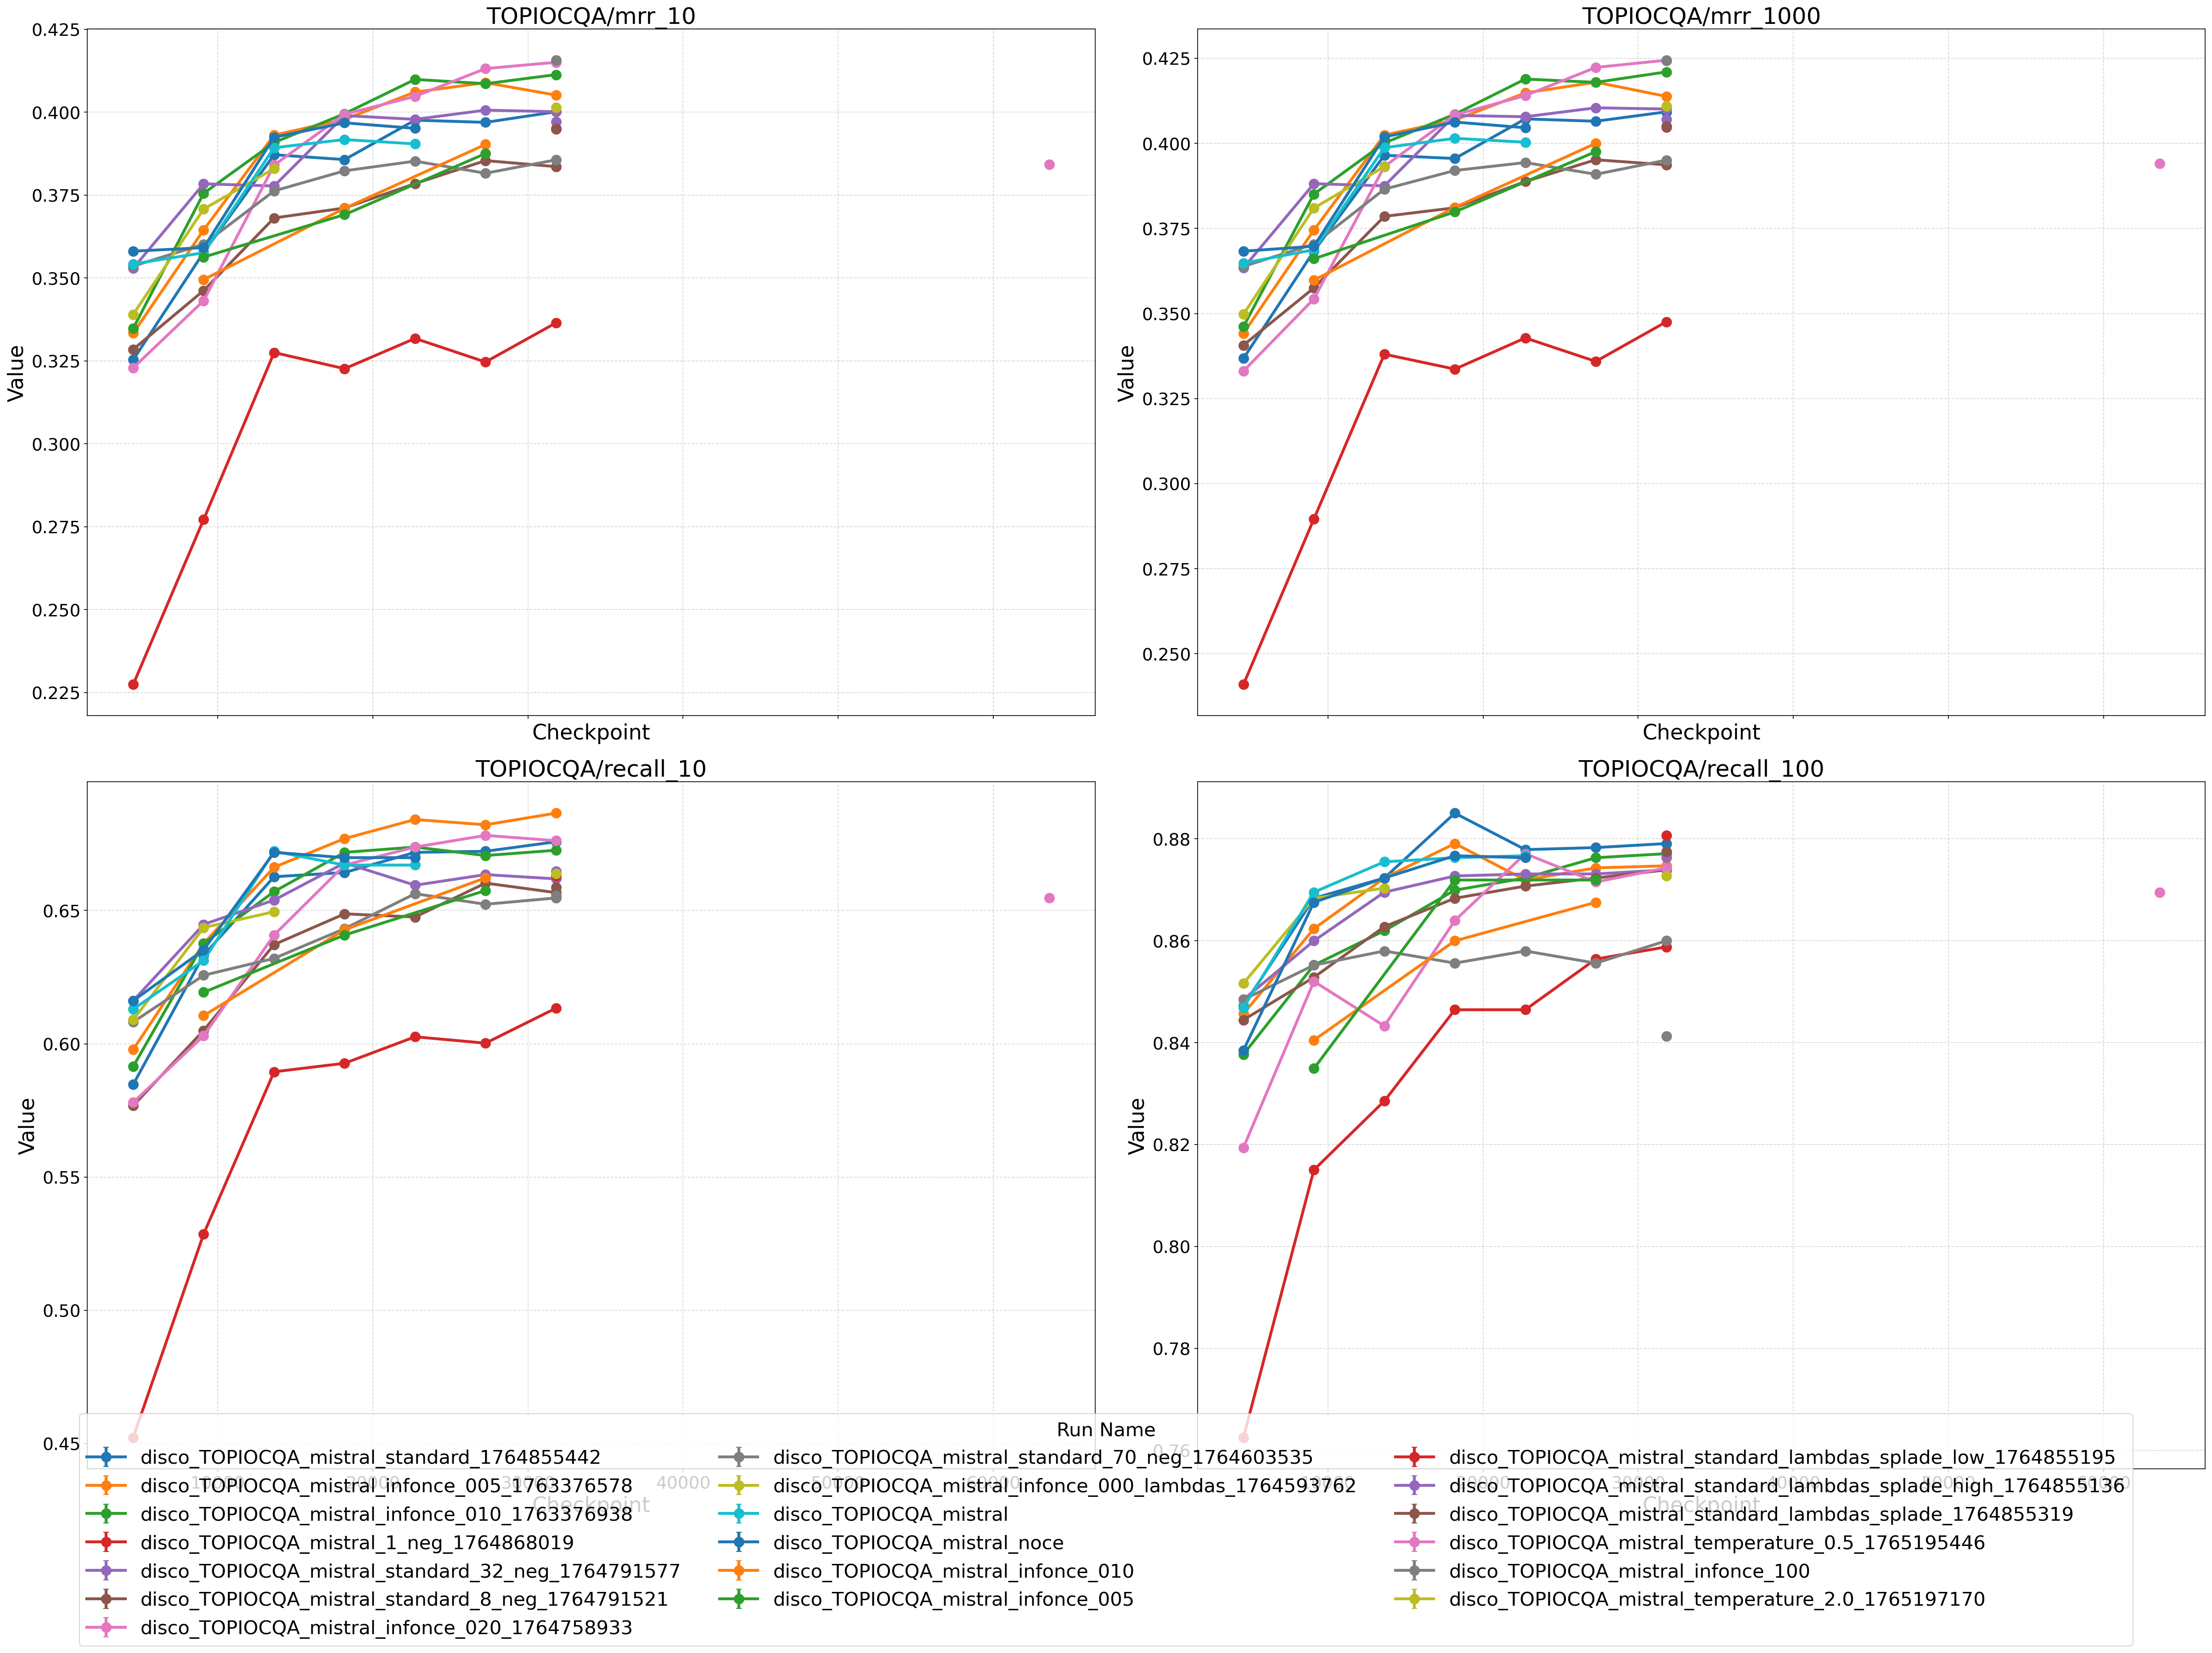

In [134]:
runs_df = runs_df[~runs_df.run_name.str.contains("3636")]
runs_df = runs_df[~runs_df.run_name.str.contains("6458")]
runs_df["runtime"] = runs_df["_wandb"].apply(lambda d: d.get("runtime"))
runs_df = runs_df[runs_df["runtime"] > 10]


metrics_to_plot = [
    "TOPIOCQA/mrr_10",
    "TOPIOCQA/mrr_1000",
    "TOPIOCQA/recall_10",
    "TOPIOCQA/recall_100",
]

run_names = runs_df["run_name"].unique()

# ---- NEW: aggregate by run & checkpoint (multiple seeds) ----
agg_df = (
    runs_df
    .groupby(["run_name", "run_checkpoint"])
    .agg({metric: ["mean", "std"] for metric in metrics_to_plot})
)

# flatten multi-index columns
agg_df.columns = [f"{metric}_{stat}" for metric, stat in agg_df.columns]
agg_df = agg_df.reset_index()

plt.rcParams.update({
    "font.size": 20,
    "axes.titlesize": 24,
    "axes.labelsize": 22,
    "legend.fontsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "lines.linewidth": 3,
    "lines.markersize": 10,
})

fig, axes = plt.subplots(
    2, 2, figsize=(32, 22), dpi=150, sharex=True, constrained_layout=True
)
axes = axes.flatten()

for ax, metric in zip(axes, metrics_to_plot):

    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"

    for run in run_names:
        df_subset = agg_df[agg_df["run_name"] == run].sort_values("run_checkpoint")

        ax.errorbar(
            df_subset["run_checkpoint"],
            df_subset[mean_col],
            yerr=df_subset[std_col],
            marker="o",
            linestyle="-",
            capsize=3,
            label=run
        )

    ax.set_title(metric)
    ax.set_xlabel("Checkpoint")
    ax.set_ylabel("Value")
    ax.grid(True, linestyle="--", alpha=0.5)

# Legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Run Name",
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.09)  # adjust this value if you want it lower or higher
)
plt.show()

In [171]:
selection_neg_sampling = ["disco_TOPIOCQA_mistral_1_neg_1764868019", "disco_TOPIOCQA_mistral_standard_70_neg_1764603535", "disco_TOPIOCQA_mistral_standard_8_neg_1764791521", "disco_TOPIOCQA_mistral_standard_32_neg_1764791577", "disco_TOPIOCQA_mistral_standard_1764855442"]
metric_list = ["TOPIOCQA/mrr_1000", "TOPIOCQA/recall_10",  "TOPIOCQA/recall_100", "TOPIOCQA/ndcg@3"]
df_subset = runs_df.loc[runs_df["run_name"].isin(selection_neg_sampling) & (runs_df.run_checkpoint==31808), ["run_name"] + metric_list].drop_duplicates().sort_values("run_name")
df_subset["run_name"] = df_subset["run_name"].apply(lambda x: int(x.split("_")[-3]) if "1764855442" not in x else 16)
df_subset.sort_values("run_name", inplace=True)
df_subset



,run_name,TOPIOCQA/mrr_1000,TOPIOCQA/recall_10,TOPIOCQA/recall_100,TOPIOCQA/ndcg@3
188,1,0.347547,0.613365,0.858791,NaN
170,8,0.393692,0.656722,0.873906,0.380623
192,16,0.409259,0.675815,0.879077,0.395909
178,32,0.410083,0.661893,0.873906,0.395430
155,70,0.395069,0.654733,0.859984,0.381475


In [170]:
selection_infonce = ["disco_TOPIOCQA_mistral_infonce_005_1763376578", "disco_TOPIOCQA_mistral_infonce_010_1763376938", "disco_TOPIOCQA_mistral_infonce_020_1764758933", "disco_TOPIOCQA_mistral_standard_1764855442", "disco_TOPIOCQA_mistral_infonce_100"]
metric_list = ["TOPIOCQA/mrr_1000", "TOPIOCQA/recall_10",  "TOPIOCQA/recall_100", "TOPIOCQA/ndcg@3"]
df_subset = runs_df.loc[runs_df["run_name"].isin(selection_infonce) & (runs_df.run_checkpoint==31808), ["run_name"] + metric_list].drop_duplicates().sort_values("run_name")
df_subset["Infonce"] = df_subset["run_name"].apply(lambda x: float(x.split("_")[-2][0] + "." + x.split("_")[-2][1:]) if "infonce_0" in x else 0)
df_subset["run_name"] = df_subset["run_name"].apply(lambda x:"Disco KL-Divergence +" + x.split("_")[-2][0] + "." + x.split("_")[-2][1:] + " InfoNCE" if "infonce" in x else "standard")
df_subset.iloc[3, df_subset.columns.get_loc("Infonce")] = 1.00
df_subset


,run_name,TOPIOCQA/mrr_1000,TOPIOCQA/recall_10,TOPIOCQA/recall_100,TOPIOCQA/ndcg@3,Infonce
198,Disco KL-Divergence +0.05 InfoNCE,0.413812,0.686555,0.874702,0.400322,0.05
44,Disco KL-Divergence +0.10 InfoNCE,0.420990,0.672633,0.877088,0.408310,0.10
165,Disco KL-Divergence +0.20 InfoNCE,0.424439,0.676213,0.874304,0.411819,0.20
195,Disco KL-Divergence +i.nfonce InfoNCE,0.424301,0.655529,0.841289,0.412099,1.00
192,standard,0.409259,0.675815,0.879077,0.395909,0.00


In [178]:
selection_infonce = ["disco_TOPIOCQA_mistral_standard_lambdas_splade_1764855319", "disco_TOPIOCQA_mistral_standard_lambdas_splade_low_1764855195", "disco_TOPIOCQA_mistral_standard_1764855442", "disco_TOPIOCQA_mistral_standard_lambdas_splade_high_1764855136"]
metric_list = ["TOPIOCQA/mrr_1000", "TOPIOCQA/recall_10",  "TOPIOCQA/recall_100", "TOPIOCQA/ndcg@3"]
df_subset = runs_df.loc[runs_df["run_name"].isin(selection_infonce) & (runs_df.run_checkpoint==31808), ["run_name"] + metric_list].drop_duplicates().sort_values("run_name")
df_subset["run_name"] = df_subset["run_name"].apply(lambda x: x.split("_")[-2] if "lambdas" in x else "Standard_Disco")
df_subset.iloc[1, df_subset.columns.get_loc("run_name")] = "medium"
df_subset

,run_name,TOPIOCQA/mrr_1000,TOPIOCQA/recall_10,TOPIOCQA/recall_100,TOPIOCQA/ndcg@3
192,Standard_Disco,0.409259,0.675815,0.879077,0.395909
191,medium,0.404963,0.658711,0.877486,0.390562
193,high,0.406992,0.664678,0.876293,0.394176
194,low,0.404780,0.663087,0.880668,0.391325


In [191]:
import json
import os

student_similarity_score_lambdas_low_results_run = "../disco_TOPIOCQA_mistral_standard_lambdas_splade_low_1764855195_out_123_ckpt15904/"
student_similarity_score_lambdas_high_results_run = "../disco_TOPIOCQA_mistral_standard_lambdas_splade_high_1764855136_out_123_ckpt15904/"
student_similarity_score_lambdas_medium_results_run = "../disco_TOPIOCQA_mistral_standard_lambdas_splade_1764855319_out_123_ckpt15904/"
student_similarity_score_disco = "../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904/"

with open(os.path.join(student_similarity_score_lambdas_low_results_run, "perf_all_datasets_full.json"), "r") as f:
    first_line = f.readline().strip()
    student_similarity_score_lambdas_low_data = json.loads(first_line)

with open(os.path.join(student_similarity_score_lambdas_high_results_run, "perf_all_datasets_full.json"), "r") as f:
    first_line = f.readline().strip()
    student_similarity_score_lambdas_high_data = json.loads(first_line)

with open(os.path.join(student_similarity_score_lambdas_medium_results_run, "perf_all_datasets_full.json"), "r") as f:
    first_line = f.readline().strip()
    student_similarity_score_lambdas_medium_data = json.loads(first_line)

with open(os.path.join(student_similarity_score_disco, "perf_all_datasets_full.json"), "r") as f:
    first_line = f.readline().strip()
    student_similarity_score_disco_data = json.loads(first_line)


In [192]:
len_dict = {}
with open("DATA/topiocqa_topics/queries_rowid_dev_all.tsv", "r") as f:
    for idx, line in enumerate(f):
        line.strip().split("\t")[1]
        len_dict[idx] = int(line.count("[SEP]")/2)

In [224]:
student_similarity_score_lambdas_low_data['TOPIOCQA']['1']

{'recall_5': 1.0,
 'recall_10': 1.0,
 'recall_15': 1.0,
 'recall_20': 1.0,
 'recall_30': 1.0,
 'recall_100': 1.0,
 'recall_200': 1.0,
 'recall_500': 1.0,
 'recall_1000': 1.0}

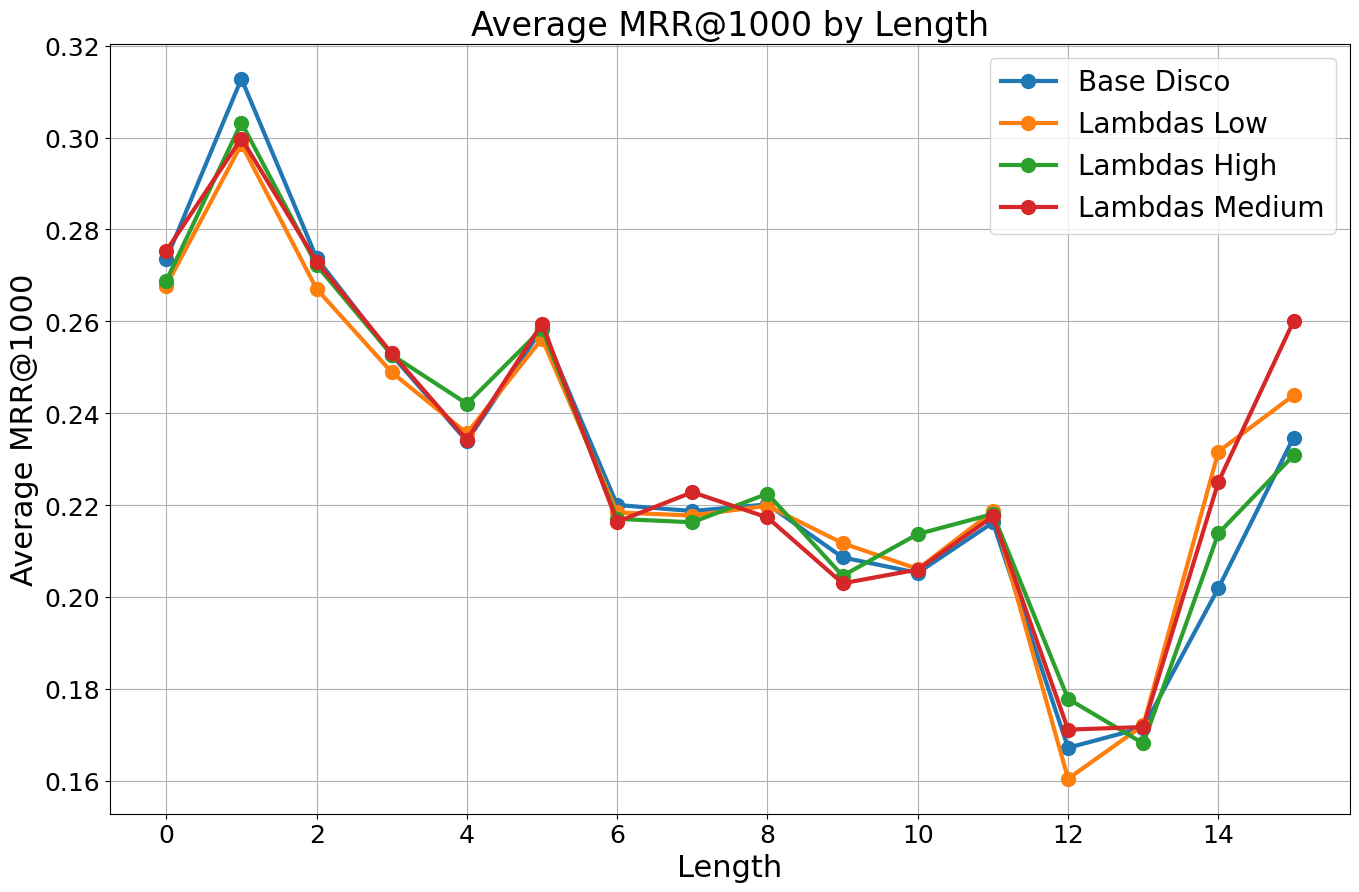

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib



def plot_avg_mrr_by_length(
    datasets, 
    len_dict, 
    labels, 
    save_path="fig.png",
    normalize=False
):
    """
    Plots average MRR@10 by length for multiple datasets, optionally normalized
    by subtracting each model's MRR at length 0.

    Args:
        datasets (list of dict): Each dict should have the same structure as base_disco_data['TOPIOCQA'].
        len_dict (dict): Mapping from sample index to length.
        labels (list of str): Labels for each dataset in the plot legend.
        save_path (str): Path to save the figure.
        normalize (bool): If True, subtract the MRR at length 0 for each dataset.
    """
    plt.figure(figsize=(16, 10))

    for data, label in zip(datasets, labels):
        mrr_values = []
        lengths = []

        for key, val in data['mrr_1000'].items():
            idx = int(key)
            mrr = val['recip_rank']
            length = len_dict.get(idx, None)
            if length is not None:
                mrr_values.append(mrr)
                lengths.append(length)

        df = pd.DataFrame({'length': lengths, 'mrr_1000': mrr_values})
        avg_df = df.groupby('length')['mrr_1000'].mean().reset_index()

        # ---- Normalization Step ----
        if normalize:
            if 0 in avg_df['length'].values:
                base_val = avg_df.loc[avg_df['length'] == 0, 'mrr_1000'].iloc[0]
                avg_df['mrr_1000'] = avg_df['mrr_1000'] - base_val
            else:
                print(f"Warning: length=0 not found for dataset '{label}', skipping normalization.")

        plt.plot(avg_df['length'], avg_df['mrr_1000'], marker='o', label=label)

    plt.xlabel('Length')
    plt.ylabel('Average MRR@1000' + (' (normalized)' if normalize else ''))
    plt.title('Average MRR@1000 by Length' + (' (Normalized)' if normalize else ''))
    plt.grid(True)
    plt.legend()
    plt.show()


plot_avg_mrr_by_length(
    datasets=[student_similarity_score_disco_data['TOPIOCQA'], student_similarity_score_lambdas_low_data['TOPIOCQA'], student_similarity_score_lambdas_high_data['TOPIOCQA'], student_similarity_score_lambdas_medium_data['TOPIOCQA']],
    len_dict=len_dict,
    labels=['Base Disco', 'Lambdas Low', 'Lambdas High', 'Lambdas Medium'],
    save_path="avg_mrr_comparison.png",
)


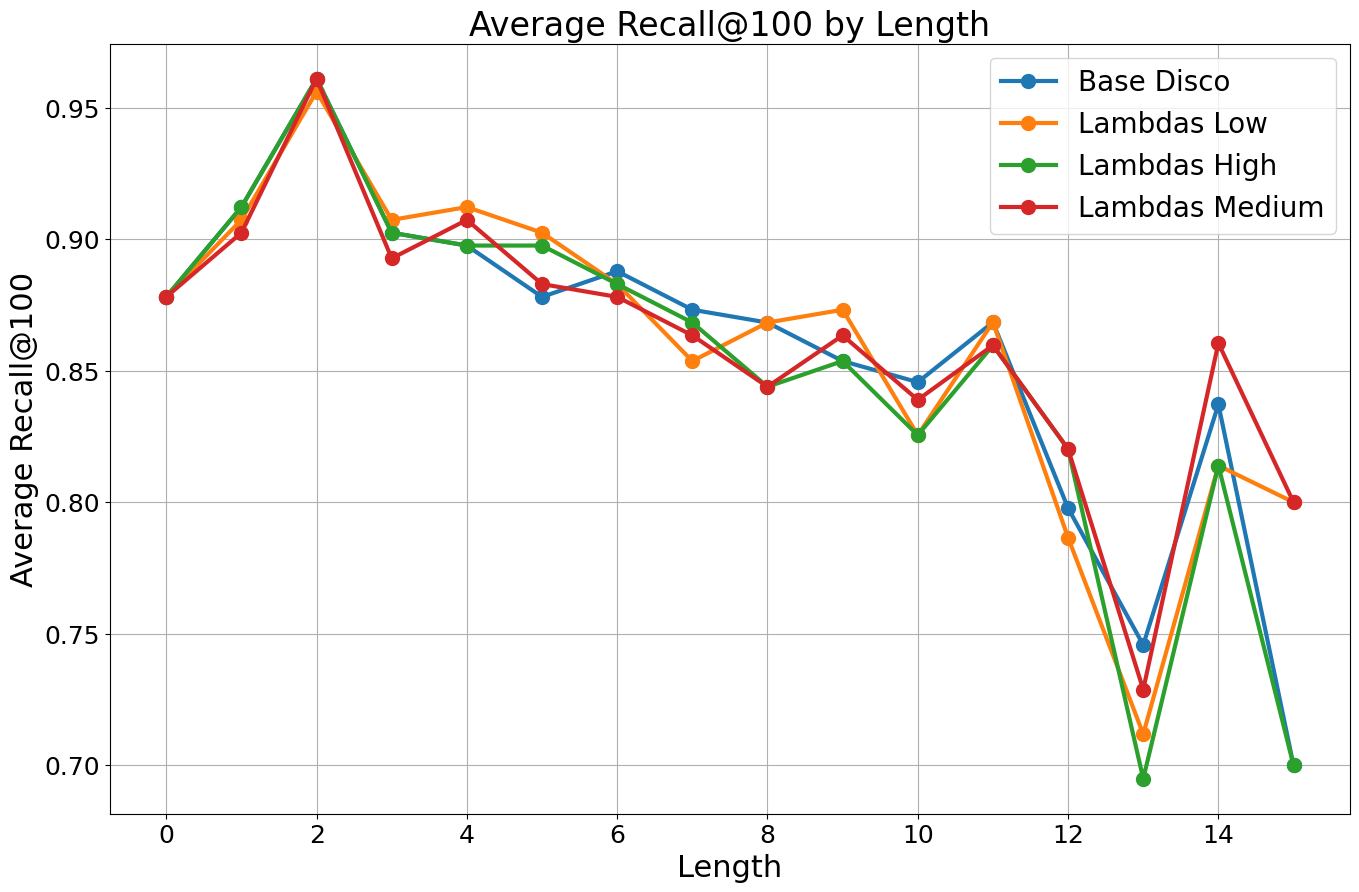

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


def plot_avg_recall_by_length(
    datasets, 
    len_dict, 
    labels, 
    save_path="fig.png",
    normalize=False
):
    """
    Plots average Recall@100 by length for multiple datasets, optionally normalized
    by subtracting each model's Recall@100 at length 0.

    Args:
        datasets (list of dict): Each dict should have the same structure as base_disco_data['TOPIOCQA'].
        len_dict (dict): Mapping from sample index to length.
        labels (list of str): Labels for each dataset in the plot legend.
        save_path (str): Path to save the figure.
        normalize (bool): If True, subtract the Recall@100 at length 0 for each dataset.
    """
    plt.figure(figsize=(16, 10))

    for data, label in zip(datasets, labels):
        recall_values = []
        lengths = []

        # Note: here `data` is already something like dataset['TOPIOCQA']
        for key, val in data.items():
            try: 
                idx = int(key)
                recall = val.get('recall_100', None)
            except:
                continue

            length = len_dict.get(idx, None)
            if length is not None and recall is not None:
                recall_values.append(recall)
                lengths.append(length)

        df = pd.DataFrame({'length': lengths, 'recall_100': recall_values})
        avg_df = df.groupby('length')['recall_100'].mean().reset_index()

        # ---- Optional Normalization ----
        if normalize:
            if 0 in avg_df['length'].values:
                base_val = avg_df.loc[avg_df['length'] == 0, 'recall_100'].iloc[0]
                avg_df['recall_100'] = avg_df['recall_100'] - base_val
            else:
                print(f"Warning: length=0 not found for dataset '{label}', skipping normalization.")

        plt.plot(avg_df['length'], avg_df['recall_100'], marker='o', label=label)

    plt.xlabel('Length')
    plt.ylabel('Average Recall@100' + (' (normalized)' if normalize else ''))
    plt.title('Average Recall@100 by Length' + (' (Normalized)' if normalize else ''))
    plt.grid(True)
    plt.legend()
    plt.savefig(save_path)
    plt.show()

plot_avg_recall_by_length(
    datasets=[
        student_similarity_score_disco_data['TOPIOCQA'],
        student_similarity_score_lambdas_low_data['TOPIOCQA'],
        student_similarity_score_lambdas_high_data['TOPIOCQA'],
        student_similarity_score_lambdas_medium_data['TOPIOCQA']
    ],
    len_dict=len_dict,
    labels=['Base Disco', 'Lambdas Low', 'Lambdas High', 'Lambdas Medium'],
    save_path="avg_recall100_comparison.png",
)


In [195]:
teacher_similarity_score_file = "DATA/topiocqa_distil/distil_run_top_mistral.json"

with open(teacher_similarity_score_file, "r") as f:
    file = json.load(f)

In [199]:
import os
os.listdir("..")

['disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_infonce_010_1763376938_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_infonce_000_lambdas_1764593762_out_123_ckpt6816',
 'disco_TOPIOCQA_mistral_standard_70_neg_1764603535_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_standard_lambdas_splade_high_1764855136_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_rewrites_out_123',
 'disco_TOPIOCQA_mistral_infonce_020_1764758933_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_out_123',
 'disco_TOPIOCQA_mistral_standard_lambdas_splade_1764855319_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_standard_lambdas_splade_low_1764855195_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_standard_32_neg_1764791577_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_infonce_005_1763376578_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_out_456_ckpt15904',
 'disco_TOPIOCQA_mistral_standard_8_neg_1764791521_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_noce_out_123_ckpt13632',
 'disco-conv-splad

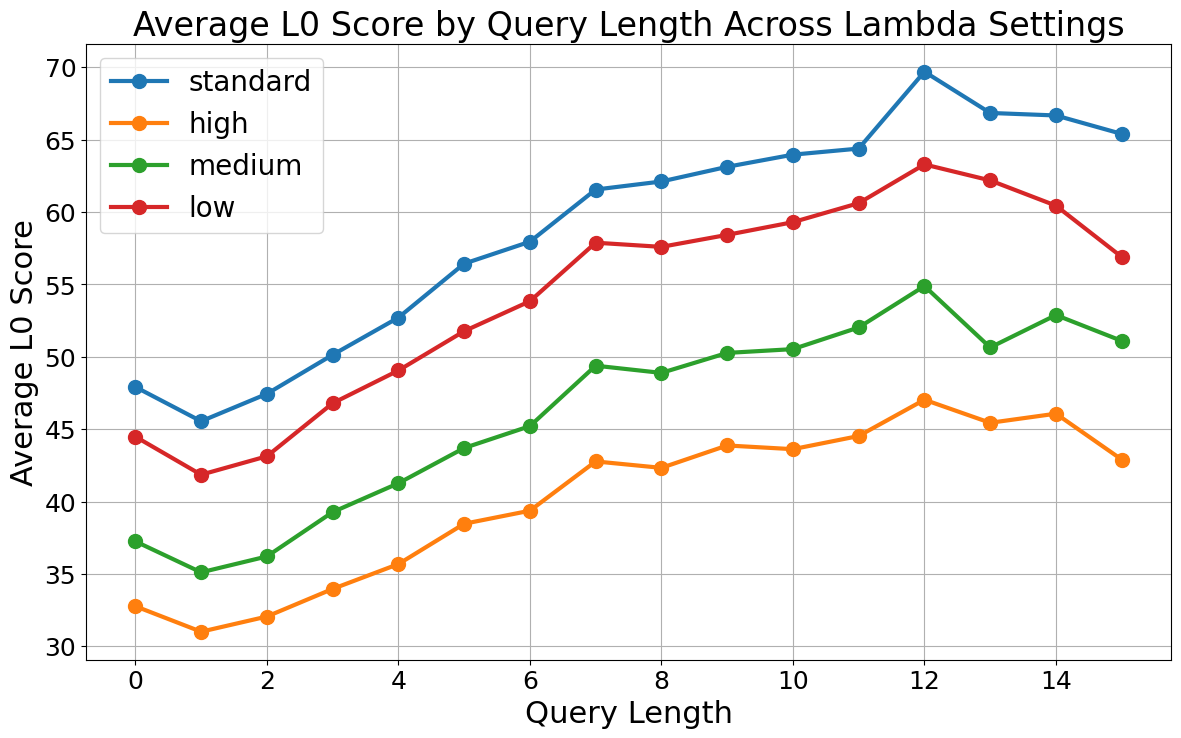

In [218]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# File paths
# -----------------------
paths = {
    "standard": "../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904/TOPIOCQA/stats/l0_stats_per_query.json",
    "high":     "../disco_TOPIOCQA_mistral_standard_lambdas_splade_high_1764855136_out_123_ckpt15904/TOPIOCQA/stats/l0_stats_per_query.json",
    "medium":   "../disco_TOPIOCQA_mistral_standard_lambdas_splade_1764855319_out_123_ckpt15904/TOPIOCQA/stats/l0_stats_per_query.json",
    "low":      "../disco_TOPIOCQA_mistral_standard_lambdas_splade_low_1764855195_out_123_ckpt15904/TOPIOCQA/stats/l0_stats_per_query.json"
}
# -----------------------
# Load JSON runs
# -----------------------
runs = {}
for name, path in paths.items():
    with open(path, "r") as f:
        runs[name] = json.load(f)

# -----------------------
# Helper: extract length + L0 for a run
# -----------------------
def extract_length_l0(results, len_dict):
    lengths = []
    l0_values = []
    
    for key, entry in results.items():
        try:
            idx = int(key)
        except:
            continue
        lengths.append(len_dict[idx])
        l0_values.append(entry)
    
    return pd.DataFrame({"length": lengths, "L0": l0_values})


# -----------------------
# Build DataFrames for each run
# -----------------------
df_runs = {}
for name, results in runs.items():
    df_runs[name] = extract_length_l0(results, len_dict)
    df_runs[name] = df_runs[name].groupby("length")["L0"].mean().reset_index()


# -----------------------
# Plot all runs together
# -----------------------
plt.figure(figsize=(14, 8))

for name, df in df_runs.items():
    plt.plot(df["length"], df["L0"], marker="o", label=name)

plt.xlabel("Query Length")
plt.ylabel("Average L0 Score")
plt.title("Average L0 Score by Query Length Across Lambda Settings")
plt.grid(True)
plt.legend()
plt.show()


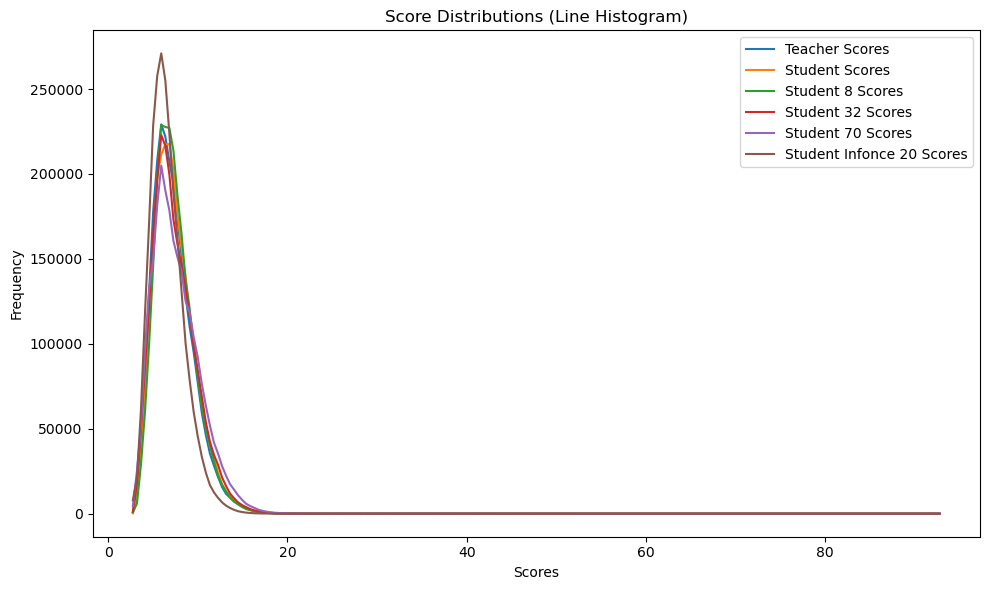

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten scores
min_queries = 1
max_queries = 2500
scores = np.fromiter(
    (v for i in range(min_queries, max_queries + 1) for v in results[str(i)].values()),
    dtype=float
)

scores_student = np.fromiter(
    (v for i in range(min_queries, max_queries + 1) for v in student_results[str(i)].values()),
    dtype=float
)

scores_student_8 = np.fromiter(
    (v for i in range(min_queries, max_queries + 1) for v in student_8_results[str(i)].values()),
    dtype=float
)

scores_student_32 = np.fromiter(
    (v for i in range(min_queries, max_queries + 1) for v in student_32_results[str(i)].values()),
    dtype=float
)

scores_student_70 = np.fromiter(
    (v for i in range(min_queries, max_queries + 1) for v in student_70_results[str(i)].values()),
    dtype=float
)

scores_student_infonce_20 = np.fromiter(
    (v for i in range(min_queries, max_queries + 1) for v in student_infonce_20_results[str(i)].values()),
    dtype=float
)
scores_train = np.fromiter(
    (v for i in range(min_queries, max_queries + 1) for v in train_results[str(i)].values()),
    dtype=float
)

# Use many bins
num_bins = 200

# Compute a global range for consistent bins
min_score = min(scores.min(), scores_student.min(), scores_student_8.min(),
                scores_student_32.min(), scores_student_70.min(), scores_student_infonce_20.min(), scores_train.min())
max_score = max(scores.max(), scores_student.max(), scores_student_8.max(),
                scores_student_32.max(), scores_student_70.max(), scores_student_infonce_20.max(), scores_train.max())

bins = np.linspace(min_score, max_score, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def hist_line(data):
    counts, _ = np.histogram(data, bins=bins)
    return counts

plt.figure(figsize=(10, 6))

plt.plot(bin_centers, hist_line(scores), label="Teacher Scores")
plt.plot(bin_centers, hist_line(scores_student), label="Student Scores")
plt.plot(bin_centers, hist_line(scores_student_8), label="Student 8 Scores")
plt.plot(bin_centers, hist_line(scores_student_32), label="Student 32 Scores")
plt.plot(bin_centers, hist_line(scores_student_70), label="Student 70 Scores")
plt.plot(bin_centers, hist_line(scores_student_infonce_20), label="Student Infonce 20 Scores")
# plt.plot(bin_centers, hist_line(scores_train), label="Teacher Train Scores")

plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.title("Score Distributions (Line Histogram)")
plt.legend()
plt.tight_layout()
plt.show()


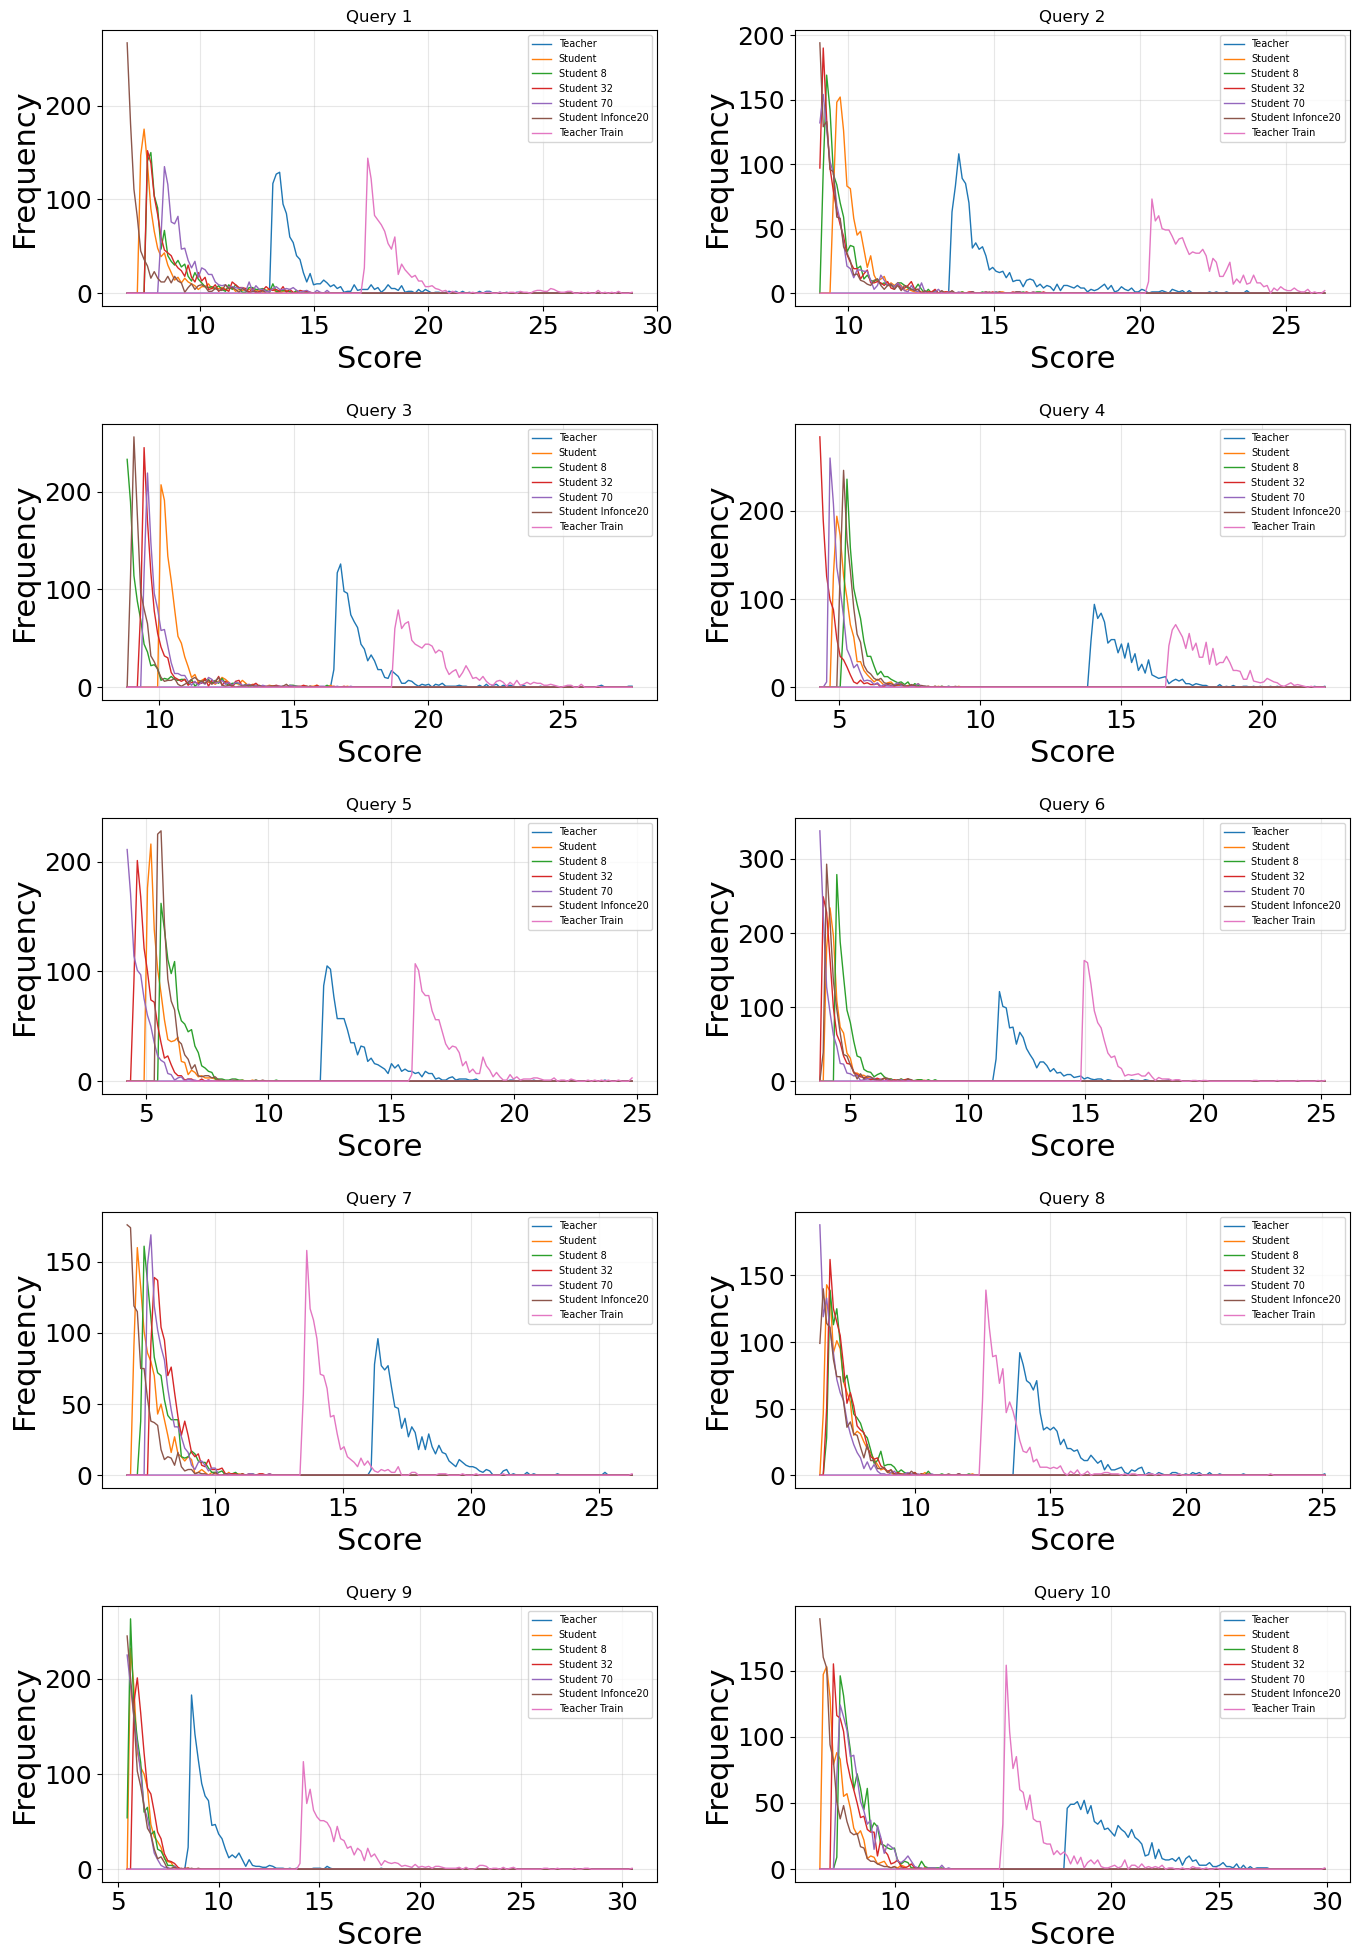

In [82]:
import numpy as np
import matplotlib.pyplot as plt

min_queries = 1
max_queries = 10   # show first 10 queries

# Helper to collect scores for a single query
def get_scores_for_query(i):
    return {
        "Teacher":           np.array(list(results[str(i)].values()), dtype=float),
        "Student":           np.array(list(student_results[str(i)].values()), dtype=float),
        "Student 8":         np.array(list(student_8_results[str(i)].values()), dtype=float),
        "Student 32":        np.array(list(student_32_results[str(i)].values()), dtype=float),
        "Student 70":        np.array(list(student_70_results[str(i)].values()), dtype=float),
        "Student Infonce20": np.array(list(student_infonce_20_results[str(i)].values()), dtype=float),
        "Teacher Train":     np.array(list(train_results[str(i)].values()), dtype=float)
    }

# Prepare figure
fig, axes = plt.subplots(5, 2, figsize=(14, 20))
axes = axes.flatten()

num_bins = 150  # many bins for resolution

for idx, query_id in enumerate(range(min_queries, max_queries + 1)):
    ax = axes[idx]
    
    # Collect all scores for this query
    data_dict = get_scores_for_query(query_id)

    # Get global min/max for consistent bins
    q_min = min(arr.min() for arr in data_dict.values())
    q_max = max(arr.max() for arr in data_dict.values())
    bins = np.linspace(q_min, q_max, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Plot each model's line-hist
    for name, arr in data_dict.items():
        counts, _ = np.histogram(arr, bins=bins)
        ax.plot(bin_centers, counts, label=name, linewidth=1)

    ax.set_title(f"Query {query_id}", fontsize=12)
    ax.set_xlabel("Score")
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [83]:
import numpy as np

def kl_divergence(p, q):
    """Discrete KL divergence D_KL(p || q)."""
    return np.sum(p * np.log(p / q))

def hist_probs(arr, bins, eps=1e-12):
    """Convert array to a smoothed discrete probability distribution."""
    counts, _ = np.histogram(arr, bins=bins)
    probs = counts.astype(float) + eps
    probs /= probs.sum()
    return probs

# ------------------------------------------------------------------
# 1. Build flattened score arrays for ALL queries
# ------------------------------------------------------------------

min_queries = 1
max_queries = 2505

scores_teacher = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in results[str(i)].values()),
    dtype=float
)

scores_student = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_results[str(i)].values()),
    dtype=float
)

scores_student_8 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_8_results[str(i)].values()),
    dtype=float
)

scores_student_32 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_32_results[str(i)].values()),
    dtype=float
)

scores_student_70 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_70_results[str(i)].values()),
    dtype=float
)

scores_infonce_20 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_infonce_20_results[str(i)].values()),
    dtype=float
)

scores_teacher_train = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in train_results[str(i)].values()),
    dtype=float
)

models = {
    "Student": scores_student,
    "Student 8": scores_student_8,
    "Student 32": scores_student_32,
    "Student 70": scores_student_70,
    "Student Infonce20": scores_infonce_20,
    "Teacher Train": scores_teacher_train,
}

# ------------------------------------------------------------------
# 2. Build global bins across *all* models and the teacher
# ------------------------------------------------------------------

all_arrays = [scores_teacher] + list(models.values())
global_min = min(arr.min() for arr in all_arrays)
global_max = max(arr.max() for arr in all_arrays)

num_bins = 300
bins = np.linspace(global_min, global_max, num_bins + 1)

teacher_probs = hist_probs(scores_teacher, bins)

# ------------------------------------------------------------------
# 3. Compute KL divergence for each model
# ------------------------------------------------------------------

klds = {}

for name, arr in models.items():
    model_probs = hist_probs(arr, bins)
    klds[name] = kl_divergence(teacher_probs, model_probs)

# ------------------------------------------------------------------
# 4. Print results
# ------------------------------------------------------------------

print("\n=== KL Divergence Over ALL 2500 Queries ===\n")
for name, val in klds.items():
    print(f"D_KL(Teacher || {name:18}) = {val:.6f}")



=== KL Divergence Over ALL 2500 Queries ===

D_KL(Teacher || Student           ) = 4.124003
D_KL(Teacher || Student 8         ) = 3.860677
D_KL(Teacher || Student 32        ) = 3.591652
D_KL(Teacher || Student 70        ) = 3.221404
D_KL(Teacher || Student Infonce20 ) = 6.584265
D_KL(Teacher || Teacher Train     ) = 0.003759
